Machine Leaning Course vol.6
# 分類問題

前回までは回帰問題に対してのアプローチを勉強してきました。

今回からは、分類問題を勉強していきます。

まずは、数回に渡って使用するあやめデータセットについて見ていきます。

In [7]:
# 必要モジュールのインポートをしておきます

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
sns.set_style('whitegrid')

## データセット 
機械学習のサンプルデータとして非常によく使われるデータセットがあります。
それが、[Iris（アヤメ）のデータ](http://en.wikipedia.org/wiki/Iris_flower_data_set) です。

このデータセットは、イギリスの統計学者ロナルド・フィッシャーによって、1936年に紹介されました。

3種類のアヤメについて、それぞれ50サンプルのデータがあります。それぞれ、Iris setosa、Iris virginica、Iris versicolorという名前がついています。全部で150のデータになっています。4つの特徴量が計測されていて、これが説明変数になります。4つのデータは、花びら（petals）と萼片（sepals）の長さと幅です。

[花びら（petals）と萼片（sepals）](https://ja.wikipedia.org/wiki/%E8%90%BC)

![](https://s3.amazonaws.com/ai-standard/pic6-1.png)

In [8]:
from sklearn.datasets import load_iris

# Irisデータのロード
iris = load_iris()

X = iris.data
y = iris.target
feature_names = iris.feature_names

#### Irisデータの表示

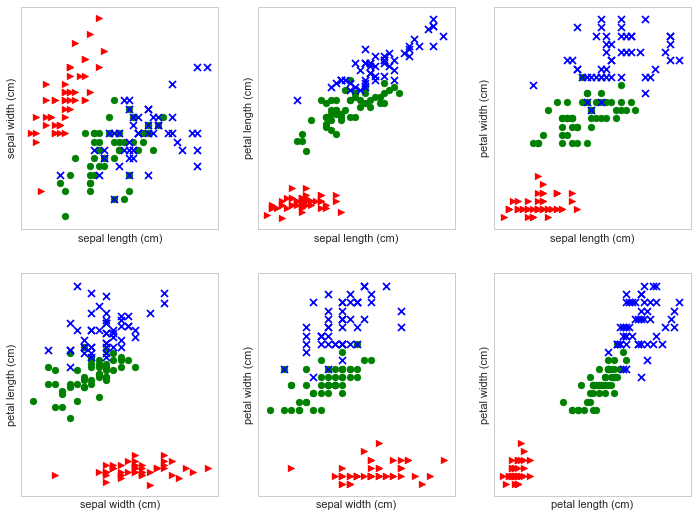

In [16]:
pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
plt.figure(figsize=(12, 9))

for i, (p0, p1) in enumerate(pairs):
    plt.subplot(2, 3, i + 1)
    for t, marker, c in zip(list(range(3)), ">ox", "rgb"):
        plt.scatter(X[iris.target == t, p0], X[iris.target == t, p1], marker=marker, c=c)
    plt.xlabel(feature_names[p0])
    plt.ylabel(feature_names[p1])
    plt.xticks([])
    plt.yticks([])

plt.show()

## データの前処理

#### データの分割
データを、トレーニングデータセットとテストデータセットに分割します。

scikit-learnには、データ分割の便利なモジュールがあるのでこれをつかいましょう。


~~~
train_test_split(特徴量[X], ラベル[Y], test_size= [テストデータの割合], random_state=[乱数生成のシード値])
~~~

In [17]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### データの整形
データはcmで統一されていますが、まずは平均を0、分散を1にする「標準化」という作業をしていきます。

##### 標準化ってなんでするの？？
標準化されてない生のデータセットは、数値の単位がバラバラ（mとｋｇ）だったらり、大きさが極端に違う（0.001と10000）などの特徴を持っていることが多いです。

このまま扱うと、特定の特徴量の影響が強く出てしまう場合があります。そこで、それぞれの特徴量のスケールを同じにそろえる作業（標準化）が必要になります。

これをすることによって、最適なパフォーマンスを実現するのに一歩近づくことになります。

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# トレーニングデータの平均と標準偏差を計算
scaler.fit(X_train)

# 平均と標準偏差を用いて標準化
X_train_std = scaler.transform(X_train)
X_test_std =  scaler.transform(X_test)

scikit-learnでは他の学習器と同じインタフェースで「標準化」が実装されています。
学習したモデルを使ってデータを変換する（標準化する）ときはpredict( )ではなく、transform( )というメソッドが定義されています。

【注意点】
テストデータを標準化するときは、同じスケーリングパラメータを適応すること。
これは、トレーニングデータとテストデータの値を相互に比較できるようにするためです。

### 単純パーセプトロン
最初に勉強する分類アルゴリズムは、「単純パーセプトロン」と呼ばれるものです。
（以降、パーセプトロンと記述する場合は、単純パーセプトロンのことを指します）

パーセプトロンは今後学習するアルゴリズムへと繋がっていく基礎的な機械学習アルゴリズムです。

まずは、パーセプトロンの基本的な概念を理解しましょう。

パーセプトロンは、ある多次元のデータを２つのカテゴリに分類するアルゴリズムです。

分類問題は、__以下の様なデータを区切る線をいかに見つけるか？__ということに着目したものです。
単純に２次元の場合を考えてみましょう。

![](https://s3.amazonaws.com/ai-standard/pic6-2.png)

普通に考えると、以下のように区切るはずです。

![](https://s3.amazonaws.com/ai-standard/pic6-3.png)

では、機械にこの線を見つけさせるためにはどうしたらいいでしょうか？

パーセプトロンの場合、この線は「ベクトル」になります。
正確には、__重みベクトルを法線とする直線__です。

重みベクトルを$w$、特定の入力値を$x$を以下に定義します。
$$
  w = \left[
    \begin{array}{r}
      w_1 \\
      w_2 \\
      \vdots \\
      w_i
    \end{array}
  \right]
$$

$$
  x = \left[
    \begin{array}{r}
      x_1 \\
      x_2 \\
      \vdots \\
      x_i
    \end{array}
  \right]
$$

そうすると、直線の方程式はこのように表せます。
$$wx=0$$

実ベクトルの内積は、各要素の積を足し上げたものなので、
$$wx=\sum^{n}_{i=1}w_ix_i = 0$$
このようにも表せる。（nは次元数）